# TnpB Library A analysis notebook

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import scipy.stats as stats
from Bio.Seq import Seq
from Bio.SeqUtils import MeltingTemp as mt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from Bio.SeqUtils import GC
import numpy as np
from collections import Counter, OrderedDict
from os import listdir
import logomaker
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import ShuffleSplit
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import shap
from itertools import product

C:\Users\nicol\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
lsize=14
titlesize=16
axesthickness = 1.5
flierprops = dict(marker='o',markersize=1.5)
boxplot_kwargs = {'widths':0.65, 'vert':True, 'patch_artist':True, 'boxprops':dict(facecolor='#FEFBF3'), 'whis':[5, 95]}
bar_kwargs = {'color':'#C5DEFF', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}
plt.rcParams['axes.linewidth'] = axesthickness
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

### Import list of all experiments

In [3]:
#path='C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Various\\07_Kim_Marquart\\TnpB\\analysis\\AnalysisFiles\\'
path='C:/Users/nicol/switchdrive/Institution/PhD/01_Experiments/05_Various/07_Kim_Marquart/TnpB/analysis/AnalysisFiles/'

def list_files1(directory):
    return [f for f in listdir(directory) if 'TnpBnuc' in f]

sampledf = pd.DataFrame(columns=['filename','Library','Cell_line','Day','Editor','Replicate'])
filelist = list_files1(path)
sampledf['filename'] = filelist
sampledf['Library'] = '12kTnpB'
sampledf['Cell_line'] = sampledf['filename'].apply(lambda x: x.split('_')[2])
sampledf['Editor'] = sampledf['filename'].apply(lambda x: x.split('_')[-2])
sampledf['Day'] = sampledf['filename'].apply(lambda x: x.split('_')[3][1:])
sampledf['Editor_Day'] = sampledf.apply(lambda x: x.Editor+'_'+x.Day ,axis=1)
sampledf['Replicate'] = sampledf['filename'].apply(lambda x: x.split('_')[-1][3:-4])
sampledf['Control'] = sampledf['filename'].apply(lambda x: True if 'CTRL' in x else False)
sampledf['repname'] = sampledf.apply(lambda x: x.Editor+"_"+x.Day+"_"+x.Replicate,axis=1)

# ANALYZE ONLY HEK293T:
sampledf = sampledf[sampledf['Cell_line'] == 'HEK293T']

In [4]:
sampledf

,filename,Library,Cell_line,Day,Editor,Replicate,Editor_Day,Control,repname
0,20220914_14-KM_HEK293T_d10_1323_TnpBnuc_rep1.csv,12kTnpB,HEK293T,10,TnpBnuc,1,TnpBnuc_10,False,TnpBnuc_10_1
1,20220914_15-KM_HEK293T_d10_1323_TnpBnuc_rep2.csv,12kTnpB,HEK293T,10,TnpBnuc,2,TnpBnuc_10,False,TnpBnuc_10_2
2,20220914_16-KM_HEK293T_d10_1323_TnpBnuc_rep3.csv,12kTnpB,HEK293T,10,TnpBnuc,3,TnpBnuc_10,False,TnpBnuc_10_3
6,20220914_20-KM_HEK293T_d10_1323_TnpBnuc_CTRL_r...,12kTnpB,HEK293T,10,CTRL,1,CTRL_10,True,CTRL_10_1
7,20220914_21-KM_HEK293T_d10_1323_TnpBnuc_CTRL_r...,12kTnpB,HEK293T,10,CTRL,2,CTRL_10,True,CTRL_10_2
8,20220914_22-KM_HEK293T_d10_1323_TnpBnuc_CTRL_r...,12kTnpB,HEK293T,10,CTRL,3,CTRL_10,True,CTRL_10_3


In [5]:
templatedf = pd.read_csv('C:/Users/nicol/switchdrive/Institution/PhD/01_Experiments/05_Various/07_Kim_Marquart/TnpB/analysis/20220517_TnpB_Library_Final_Dataframe.csv')
# Remove rows with duplicates in 'spacer'
templatedf = templatedf[~(templatedf.duplicated(["spacer"], keep=False) & (templatedf["lib_section"]!="Custom_library_variants"))]


### Calculate control characteristics for each experimental setup

In [6]:
dataframe = pd.read_csv(path+'20220914_20-KM_HEK293T_d10_1323_TnpBnuc_CTRL_rep1.csv')
dataframe

,Unnamed: 0.1,Unnamed: 0,Identifier,lib_section,specific_primerpart,barcode,spacer,target_rv,oligofinal,length,spacer_part,Spacer_Length,target,uneditedcount,indelcount,totalreads
0,0,0,SUB_ID_1_1MM_pur_oRNA_DNMT1_1054_mouse,Custom_library_variants,GACTGTCTACCACTTGTACTTCAGC,TACGTGC,GTCAGTGTGATAGGATCCGT,ATCACGGATCCTAT,GACTTTAGTCGTGTGAGGTTCAAGTCAGTGTGATAGGATCCGTGGC...,200,GTCAGTGTGA,20,ATAGGATCCGTGAT,2365,94,2459
1,1,1,SUB_ID_2_1MM_pur_oRNA_DNMT1_1054_mouse,Custom_library_variants,GACTGTCTACCACTTGTACTTCAGC,GACGTCG,GTCAGTGTGATAGGATCCGT,ATCACGGATCCTAT,GACTTTAGTCGTGTGAGGTTCAAGTCAGTGTGATAGGATCCGTGGC...,200,GTCAGTGTGA,20,ATAGGATCCGTGAT,2100,188,2288
2,2,2,SUB_ID_3_1MM_pur_oRNA_DNMT1_1054_mouse,Custom_library_variants,GACTGTCTACCACTTGTACTTCAGC,GAACATC,GTCAGTGTGATAGGATCCGT,ATCACGGATCCTAT,GACTTTAGTCGTGTGAGGTTCAAGTCAGTGTGATAGGATCCGTGGC...,200,GTCAGTGTGA,20,ATAGGATCCGTGAT,2341,66,2407
3,3,3,SUB_ID_4_1MM_pur_oRNA_DNMT1_1054_mouse,Custom_library_variants,GACTGTCTACCACTTGTACTTCAGC,ATTTCCT,GTCAGTGTGATAGGATCCGT,ATCACGGATCCTAT,GACTTTAGTCGTGTGAGGTTCAAGTCAGTGTGATAGGATCCGTGGC...,200,GTCAGTGTGA,20,ATAGGATCCGTGAT,2077,66,2143
4,4,4,SUB_ID_5_1MM_pur_oRNA_DNMT1_1054_mouse,Custom_library_variants,GACTGTCTACCACTTGTACTTCAGC,AGGCGAC,GTCAGTGTGATAGGATCCGT,ATCACGGATCCTAT,GACTTTAGTCGTGTGAGGTTCAAGTCAGTGTGATAGGATCCGTGGC...,200,GTCAGTGTGA,20,ATAGGATCCGTGAT,2206,68,2274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11995,10795,Chr15_10346495:10348642_Fw_2078,mouse_exon_variants,GCTACTCTACCACTTGTACTTCAGC,TCGATGT,CCTCTTAGACCTCTTTAAAT,TTTATTTAAAGAGG,GACTTTAGTCGTGTGAGGTTCAACCTCTTAGACCTCTTTAAATGGC...,200,CCTCTTAGAC,20,CCTCTTTAAATAAA,1071,49,1120
11996,11996,10796,Chr3_88618936:88620231_Rv_840,mouse_exon_variants,GCTACTCTACCACTTGTACTTCAGC,GTGCTTA,GCAAATTTGTGATTCTAAGT,TTCACTTAGAATCA,GACTTTAGTCGTGTGAGGTTCAAGCAAATTTGTGATTCTAAGTGGC...,200,GCAAATTTGT,20,TGATTCTAAGTGAA,989,37,1026
11997,11997,10797,Chr9_37049848:37050920_Rv_902,mouse_exon_variants,GCTACTCTACCACTTGTACTTCAGC,ATTCCTC,CCCAGCACTCGGAGGAGGCA,CTCTGCCTCCTCCG,GACTTTAGTCGTGTGAGGTTCAACCCAGCACTCGGAGGAGGCAGGC...,200,CCCAGCACTC,20,CGGAGGAGGCAGAG,1754,47,1801
11998,11998,10798,Chr4_115691318:115693382_Fw_1053,mouse_exon_variants,GCTACTCTACCACTTGTACTTCAGC,GACTCAG,CCCTCAGGGTCCCCTGGATC,CAAGATCCAGGGGA,GACTTTAGTCGTGTGAGGTTCAACCCTCAGGGTCCCCTGGATCGGC...,200,CCCTCAGGGT,20,TCCCCTGGATCTTG,990,61,1051


In [7]:
ctrllist = sampledf[sampledf['Editor'] == 'CTRL']
ctrldf = templatedf.copy()
for index, row in ctrllist.iterrows():
    controlrepdf = pd.read_csv(path+row.filename)
    ctrldf[row.repname+'_totalreads'] = controlrepdf['totalreads']
    controlrepdf['percentageindel'] = controlrepdf.apply(lambda x: (x.indelcount/x.totalreads)*100 ,axis=1)
    controlrepdf['percentageunedited'] = controlrepdf.apply(lambda x: (x.uneditedcount/x.totalreads)*100 ,axis=1)
    ctrldf[row.repname+'_percentageunedited'] = controlrepdf['percentageunedited']
    ctrldf[row.repname+'_percentageindel'] = controlrepdf['percentageindel']
    ctrldf[row.repname+'_uneditedcount'] = controlrepdf['uneditedcount']
    ctrldf[row.repname+'_indelcount'] = controlrepdf['indelcount']

for index, row in ctrllist.iterrows():    
    ctrldf = ctrldf[ctrldf[row.repname+'_totalreads'] > 100]
    ctrldf = ctrldf[ctrldf[row.repname+'_percentageindel'] < 15]

In [8]:
ctrldf

,Unnamed: 0,Identifier,lib_section,specific_primerpart,barcode,spacer,target_rv,oligofinal,length,CTRL_10_1_totalreads,...,CTRL_10_2_totalreads,CTRL_10_2_percentageunedited,CTRL_10_2_percentageindel,CTRL_10_2_uneditedcount,CTRL_10_2_indelcount,CTRL_10_3_totalreads,CTRL_10_3_percentageunedited,CTRL_10_3_percentageindel,CTRL_10_3_uneditedcount,CTRL_10_3_indelcount
0,0,SUB_ID_1_1MM_pur_oRNA_DNMT1_1054_mouse,Custom_library_variants,GACTGTCTACCACTTGTACTTCAGC,GCACGTA,GTCAGTGTGATAGGATCCGT,ATCACGGATCCTAT,GACTTTAGTCGTGTGAGGTTCAAGTCAGTGTGATAGGATCCGTGGC...,200,2459,...,2701,97.223251,2.776749,2626,75,2607,96.547756,3.452244,2517,90
1,1,SUB_ID_2_1MM_pur_oRNA_DNMT1_1054_mouse,Custom_library_variants,GACTGTCTACCACTTGTACTTCAGC,CGACGTC,GTCAGTGTGATAGGATCCGT,ATCACGGATCCTAT,GACTTTAGTCGTGTGAGGTTCAAGTCAGTGTGATAGGATCCGTGGC...,200,2288,...,2582,93.609605,6.390395,2417,165,2404,93.469218,6.530782,2247,157
2,2,SUB_ID_3_1MM_pur_oRNA_DNMT1_1054_mouse,Custom_library_variants,GACTGTCTACCACTTGTACTTCAGC,GATGTTC,GTCAGTGTGATAGGATCCGT,ATCACGGATCCTAT,GACTTTAGTCGTGTGAGGTTCAAGTCAGTGTGATAGGATCCGTGGC...,200,2407,...,2725,96.587156,3.412844,2632,93,2370,97.130802,2.869198,2302,68
3,3,SUB_ID_4_1MM_pur_oRNA_DNMT1_1054_mouse,Custom_library_variants,GACTGTCTACCACTTGTACTTCAGC,AGGAAAT,GTCAGTGTGATAGGATCCGT,ATCACGGATCCTAT,GACTTTAGTCGTGTGAGGTTCAAGTCAGTGTGATAGGATCCGTGGC...,200,2143,...,2470,97.044534,2.955466,2397,73,2276,97.275923,2.724077,2214,62
4,4,SUB_ID_5_1MM_pur_oRNA_DNMT1_1054_mouse,Custom_library_variants,GACTGTCTACCACTTGTACTTCAGC,GTCGCCT,GTCAGTGTGATAGGATCCGT,ATCACGGATCCTAT,GACTTTAGTCGTGTGAGGTTCAAGTCAGTGTGATAGGATCCGTGGC...,200,2274,...,2588,97.063369,2.936631,2512,76,2403,96.754057,3.245943,2325,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,10795,Chr15_10346495:10348642_Fw_2078,mouse_exon_variants,GCTACTCTACCACTTGTACTTCAGC,ACATCGA,CCTCTTAGACCTCTTTAAAT,TTTATTTAAAGAGG,GACTTTAGTCGTGTGAGGTTCAACCTCTTAGACCTCTTTAAATGGC...,200,1120,...,1258,95.866455,4.133545,1206,52,1104,96.467391,3.532609,1065,39
11996,10796,Chr3_88618936:88620231_Rv_840,mouse_exon_variants,GCTACTCTACCACTTGTACTTCAGC,TAAGCAC,GCAAATTTGTGATTCTAAGT,TTCACTTAGAATCA,GACTTTAGTCGTGTGAGGTTCAAGCAAATTTGTGATTCTAAGTGGC...,200,1026,...,1208,96.274834,3.725166,1163,45,1072,97.108209,2.891791,1041,31
11997,10797,Chr9_37049848:37050920_Rv_902,mouse_exon_variants,GCTACTCTACCACTTGTACTTCAGC,GAGGAAT,CCCAGCACTCGGAGGAGGCA,CTCTGCCTCCTCCG,GACTTTAGTCGTGTGAGGTTCAACCCAGCACTCGGAGGAGGCAGGC...,200,1801,...,2085,96.594724,3.405276,2014,71,1814,96.968026,3.031974,1759,55
11998,10798,Chr4_115691318:115693382_Fw_1053,mouse_exon_variants,GCTACTCTACCACTTGTACTTCAGC,CTGAGTC,CCCTCAGGGTCCCCTGGATC,CAAGATCCAGGGGA,GACTTTAGTCGTGTGAGGTTCAACCCTCAGGGTCCCCTGGATCGGC...,200,1051,...,1212,95.214521,4.785479,1154,58,989,95.551062,4.448938,945,44


In [9]:
editordaylist = sampledf['Editor_Day'].unique()
editordaylist = [x for x in editordaylist if not 'CTRL' in x]
experimentdict = {}
for editor_day in editordaylist:
    experimentdf = templatedf.copy()
    for index, row in sampledf[sampledf['Editor_Day'] == editor_day].iterrows():
        dataframe = pd.read_csv(path+row.filename)
        dataframename = row.Editor+"_"+row.Day+"_"+row.Replicate
        experimentdf[dataframename+'_totalreads'] = dataframe['totalreads']
        dataframe['percentageindel'] = dataframe.apply(lambda x: (x.indelcount/x.totalreads)*100 ,axis=1)
        dataframe['percentageunedited'] = dataframe.apply(lambda x: (x.uneditedcount/x.totalreads)*100 ,axis=1)
        experimentdf[dataframename+'_percentageunedited'] = dataframe['percentageunedited']
        experimentdf[dataframename+'_percentageindel'] = dataframe['percentageindel']
        experimentdf[dataframename+'_uneditedcount'] = dataframe['uneditedcount']
        experimentdf[dataframename+'_indelcount'] = dataframe['indelcount']
    replicates = list(sampledf[sampledf['Editor_Day'] == editor_day].repname)
    controldf = sampledf[(sampledf['Editor'] == 'ctr')]
    #controlname = controldf['Cell_line_Editor'] + '_' + controldf['Replicate']
    
    ctrluneditedlist = []
    ctrlindellist = []
    lib = "TnpB12k"
    for index, row in ctrllist.iterrows():
        ctrluneditedlist.append(row.repname+'_percentageunedited')
        ctrlindellist.append(row.repname+'_percentageindel')
        
    experimentdf[lib+'_ctr'+'_percentageunedited'] = ctrldf[ctrluneditedlist].mean(axis=1)
    experimentdf[lib+'_ctr'+'_percentageindel'] = ctrldf[ctrlindellist].mean(axis=1)

    cutoff = 100
    initialtemplen = len(experimentdf)

    for replicate in replicates:
        experimentdf = experimentdf[experimentdf[replicate+'_totalreads']>cutoff]

    experimentdict[editor_day] = experimentdf

In [10]:
experimentdf

,Unnamed: 0,Identifier,lib_section,specific_primerpart,barcode,spacer,target_rv,oligofinal,length,TnpBnuc_10_1_totalreads,...,TnpBnuc_10_2_percentageindel,TnpBnuc_10_2_uneditedcount,TnpBnuc_10_2_indelcount,TnpBnuc_10_3_totalreads,TnpBnuc_10_3_percentageunedited,TnpBnuc_10_3_percentageindel,TnpBnuc_10_3_uneditedcount,TnpBnuc_10_3_indelcount,TnpB12k_ctr_percentageunedited,TnpB12k_ctr_percentageindel
0,0,SUB_ID_1_1MM_pur_oRNA_DNMT1_1054_mouse,Custom_library_variants,GACTGTCTACCACTTGTACTTCAGC,GCACGTA,GTCAGTGTGATAGGATCCGT,ATCACGGATCCTAT,GACTTTAGTCGTGTGAGGTTCAAGTCAGTGTGATAGGATCCGTGGC...,200,2438.0,...,7.318653,1431,113,1636.0,90.892421,9.107579,1487,149,96.649438,3.350562
1,1,SUB_ID_2_1MM_pur_oRNA_DNMT1_1054_mouse,Custom_library_variants,GACTGTCTACCACTTGTACTTCAGC,CGACGTC,GTCAGTGTGATAGGATCCGT,ATCACGGATCCTAT,GACTTTAGTCGTGTGAGGTTCAAGTCAGTGTGATAGGATCCGTGGC...,200,2494.0,...,19.594203,1387,338,1655.0,79.335347,20.664653,1313,342,92.954013,7.045987
2,2,SUB_ID_3_1MM_pur_oRNA_DNMT1_1054_mouse,Custom_library_variants,GACTGTCTACCACTTGTACTTCAGC,GATGTTC,GTCAGTGTGATAGGATCCGT,ATCACGGATCCTAT,GACTTTAGTCGTGTGAGGTTCAAGTCAGTGTGATAGGATCCGTGGC...,200,2468.0,...,4.067584,1533,65,1617.0,94.805195,5.194805,1533,84,96.991985,3.008015
3,3,SUB_ID_4_1MM_pur_oRNA_DNMT1_1054_mouse,Custom_library_variants,GACTGTCTACCACTTGTACTTCAGC,AGGAAAT,GTCAGTGTGATAGGATCCGT,ATCACGGATCCTAT,GACTTTAGTCGTGTGAGGTTCAAGTCAGTGTGATAGGATCCGTGGC...,200,2152.0,...,7.654836,1327,110,1415.0,90.176678,9.823322,1276,139,97.080221,2.919779
4,4,SUB_ID_5_1MM_pur_oRNA_DNMT1_1054_mouse,Custom_library_variants,GACTGTCTACCACTTGTACTTCAGC,GTCGCCT,GTCAGTGTGATAGGATCCGT,ATCACGGATCCTAT,GACTTTAGTCGTGTGAGGTTCAAGTCAGTGTGATAGGATCCGTGGC...,200,2276.0,...,6.981520,1359,102,1395.0,92.688172,7.311828,1293,102,96.942367,3.057633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,10795,Chr15_10346495:10348642_Fw_2078,mouse_exon_variants,GCTACTCTACCACTTGTACTTCAGC,ACATCGA,CCTCTTAGACCTCTTTAAAT,TTTATTTAAAGAGG,GACTTTAGTCGTGTGAGGTTCAACCTCTTAGACCTCTTTAAATGGC...,200,917.0,...,3.281853,501,17,631.0,97.147385,2.852615,613,18,95.986282,4.013718
11996,10796,Chr3_88618936:88620231_Rv_840,mouse_exon_variants,GCTACTCTACCACTTGTACTTCAGC,TAAGCAC,GCAAATTTGTGATTCTAAGT,TTCACTTAGAATCA,GACTTTAGTCGTGTGAGGTTCAAGCAAATTTGTGATTCTAAGTGGC...,200,758.0,...,5.294118,483,27,456.0,94.298246,5.701754,430,26,96.592269,3.407731
11997,10797,Chr9_37049848:37050920_Rv_902,mouse_exon_variants,GCTACTCTACCACTTGTACTTCAGC,GAGGAAT,CCCAGCACTCGGAGGAGGCA,CTCTGCCTCCTCCG,GACTTTAGTCGTGTGAGGTTCAACCCAGCACTCGGAGGAGGCAGGC...,200,1669.0,...,3.613369,1067,40,930.0,95.376344,4.623656,887,43,96.984363,3.015637
11998,10798,Chr4_115691318:115693382_Fw_1053,mouse_exon_variants,GCTACTCTACCACTTGTACTTCAGC,CTGAGTC,CCCTCAGGGTCCCCTGGATC,CAAGATCCAGGGGA,GACTTTAGTCGTGTGAGGTTCAACCCTCAGGGTCCCCTGGATCGGC...,200,825.0,...,7.620818,497,41,536.0,93.097015,6.902985,499,37,94.987196,5.012804


### Calculate editing characteristics for all experimental setups
Also clip editing levels to be between 0-100.

In [11]:
sampledf_woctr = sampledf[sampledf['Editor'] != 'CTRL']

In [12]:
editordaydf = sampledf_woctr.copy()
editordaydf = editordaydf[editordaydf['Replicate'] == "1"]
editordaydf = editordaydf.set_index('Editor_Day')

cols = ['Editor','Cell_line', 'Library', 'Day']
editordaydf = editordaydf[cols]
editordaydf

,Editor,Cell_line,Library,Day
Editor_Day,,,,
TnpBnuc_10,TnpBnuc,HEK293T,12kTnpB,10


In [13]:
for editor_day in experimentdict:
    print(editor_day)
    replicatelist = list(sampledf_woctr[sampledf_woctr['Editor_Day'] == editor_day]['repname'])
    ctrname = lib+'_ctr'
    
    for replicate in replicatelist:
        print(replicate)
        repnr = replicate.split('_')[-1]
        experimentdict[editor_day][replicate+'_percentageindel_corrected_individual'] = experimentdict[editor_day].apply(lambda x: ((x[replicate+'_percentageindel']-x[ctrname+'_percentageindel'])/((100-x[ctrname+'_percentageindel'])/100)),axis=1)
        editordaydf.at[editor_day,repnr +'_meanindel'] = None
        editordaydf.at[editor_day,repnr +'_meanindel'] = experimentdict[editor_day][[replicate +'_percentageindel_corrected_individual']].mean()
        
    allreps = []
    for index,row in sampledf_woctr[sampledf_woctr['Editor_Day'] == editor_day].iterrows():
        rep = row.Editor_Day+'_'+row.Replicate
        allreps.append(rep)
        
    print(allreps)    
    experimentdict[editor_day][editor_day+'_averageindel'] = experimentdict[editor_day][[x +'_percentageindel_corrected_individual' for x in allreps]].mean(axis=1)
    
       
    # Clip editing rates to be between 0 and 100
    experimentdict[editor_day][editor_day+'_averageindel'] = experimentdict[editor_day][editor_day+'_averageindel'].clip(0,100)
    
    experimentdict[editor_day] = experimentdict[editor_day].dropna(subset=[editor_day+'_averageindel'])
    
    replist = ['1_meanindel','2_meanindel','3_meanindel']
    
    
    
    
    editordaydf.at[editor_day,'numberofvariants'] = len(experimentdict[editor_day])
    editordaydf.at[editor_day,'meanindel'] = experimentdict[editor_day][editor_day+'_averageindel'].mean()
    editordaydf.at[editor_day,'standarddeviation'] = experimentdict[editor_day][editor_day+'_averageindel'].std()
    experimentdict[editor_day].to_csv('.//AnalysisFiles//summary//20221219_'+editor_day+'_analysis_dataframe.csv')

TnpBnuc_10
TnpBnuc_10_1
TnpBnuc_10_2
TnpBnuc_10_3
['TnpBnuc_10_1', 'TnpBnuc_10_2', 'TnpBnuc_10_3']


In [14]:
for index, row in editordaydf.iterrows():
    editordaydf.at[index,'replicate_meanindel'] = (row['1_meanindel'] + row['2_meanindel'] + row['3_meanindel']) / 3
    editordaydf.at[index,'replicate_std'] = np.std([row['1_meanindel'],row['2_meanindel'],row['3_meanindel']])

In [15]:
editordaydf['Day'] = editordaydf['Day'].apply(lambda x: int(x))
editordaydf = editordaydf.sort_values('Day')
editordaydf = editordaydf.sort_values('Editor')
editordaydf['filename'] = editordaydf.apply(lambda x: '20220912_'+x.Editor+'_'+str(x.Day)+'_analysis_dataframe.csv',axis=1)
editordaydf.to_csv('.//AnalysisFiles//summary//20221219_12kTnpB_summary_mean_std.csv')
editordaydf

,Editor,Cell_line,Library,Day,1_meanindel,2_meanindel,3_meanindel,numberofvariants,meanindel,standarddeviation,replicate_meanindel,replicate_std,filename
Editor_Day,,,,,,,,,,,,,
TnpBnuc_10,TnpBnuc,HEK293T,12kTnpB,10,8.437116,8.589014,8.697204,10696.0,8.63455,9.419856,8.574445,0.106679,20220912_TnpBnuc_10_analysis_dataframe.csv


In [16]:
replicate_cols = ['TnpBnuc_10_1_percentageindel_corrected_individual','TnpBnuc_10_2_percentageindel_corrected_individual','TnpBnuc_10_3_percentageindel_corrected_individual']
uncorrected_replicate_cols = ['TnpBnuc_10_1_percentageindel','TnpBnuc_10_2_percentageindel','TnpBnuc_10_3_percentageindel']

combinations = [(1,2),(1,3),(2,3)]

for combination in combinations:
    print('Spearman correlation of replicates (corrected)',combination)
    correlation = experimentdict['TnpBnuc_10'][replicate_cols[combination[0]-1]].corr(experimentdict['TnpBnuc_10'][replicate_cols[combination[1]-1]],method='spearman')
    print(correlation)
    print('Spearman correlation of replicates (uncorrected)',combination)
    correlation = experimentdict['TnpBnuc_10'][uncorrected_replicate_cols[combination[0]-1]].corr(experimentdict['TnpBnuc_10'][uncorrected_replicate_cols[combination[1]-1]],method='spearman')
    print(correlation)
    print()

Spearman correlation of replicates (corrected) (1, 2)
0.9573445688037439
Spearman correlation of replicates (uncorrected) (1, 2)
0.9652163829263392

Spearman correlation of replicates (corrected) (1, 3)
0.957800753209715
Spearman correlation of replicates (uncorrected) (1, 3)
0.9656489007288822

Spearman correlation of replicates (corrected) (2, 3)
0.9479398351687855
Spearman correlation of replicates (uncorrected) (2, 3)
0.9574642942911217



meta NOT subset; don't know how to subset; dropped


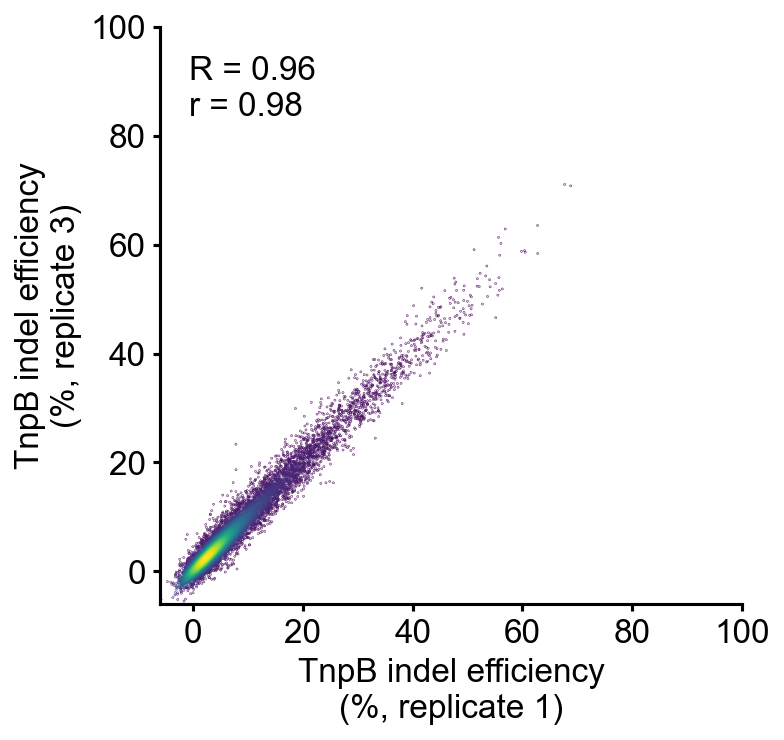

In [19]:
rep1eff = experimentdict['TnpBnuc_10']['TnpBnuc_10_1_percentageindel_corrected_individual'].reset_index(drop=True)
rep3eff = experimentdict['TnpBnuc_10']['TnpBnuc_10_3_percentageindel_corrected_individual'].reset_index(drop=True)
xy = np.vstack([rep1eff,rep3eff])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
Correlation_x, Correlation_y, Correlation_z_1_3 = rep1eff[idx], rep3eff[idx], z[idx]
rep1_3_R = stats.spearmanr(rep1eff, rep3eff)[0]
rep1_3_r = stats.pearsonr(rep1eff, rep3eff)[0]
fig, ax = plt.subplots(figsize = (5, 5),dpi=150)
ax.scatter(Correlation_x, Correlation_y, c=Correlation_z_1_3, s=0.05)
xlabels=[0,20,40,60,80,100]
# ax.xaxis.set_tick_params(width=2)
ax.tick_params(axis='x', labelsize= 16, width=1.5)
ax.tick_params(axis='y', labelsize= 16, width=1.5)
ax.set_xlabel('TnpB indel efficiency\n(%, replicate 1)', fontsize=16)
ax.set_ylabel('TnpB indel efficiency\n(%, replicate 3)', fontsize=16)
ax.set_xlim(-6, 100)
ax.set_ylim(-6, 100)
ax.set_xticks([0,20,40,60,80,100])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(0.05, 0.95, 'R = '+str(round(rep1_3_R, 2))+'\nr = '+str(round(rep1_3_r, 2)), transform=ax.transAxes, fontsize=16,
        verticalalignment='top')
figurepath = 'C:/Users/nicol/switchdrive/Institution/PhD/01_Experiments/05_Various/07_Kim_Marquart/TnpB/analysis/figures/'
plt.savefig(figurepath+'tnpB_indel_r1_r3_individual_correlation.pdf', format='pdf',
        transparent=True,bbox_inches='tight')
plt.show()

meta NOT subset; don't know how to subset; dropped


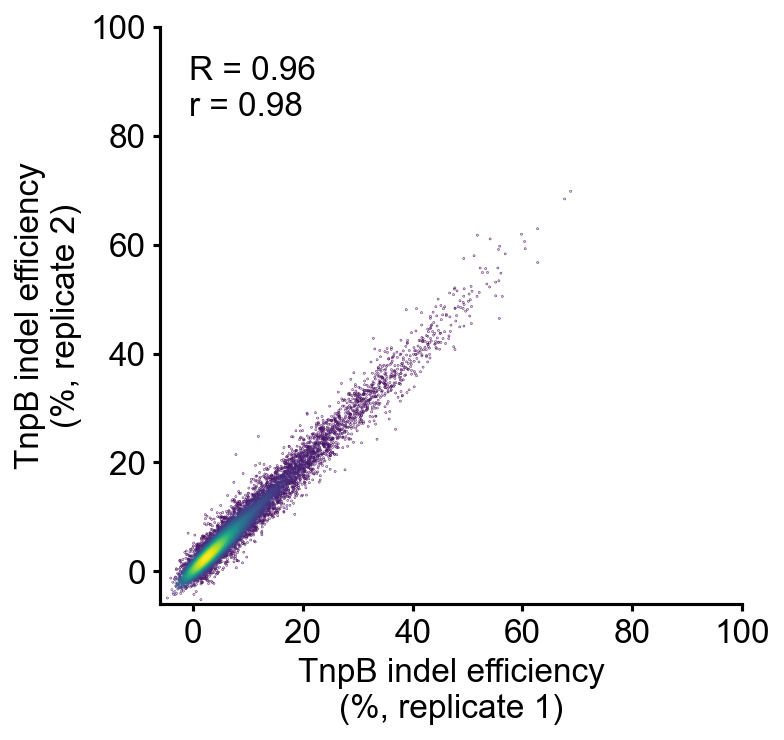

In [20]:
rep1eff = experimentdict['TnpBnuc_10']['TnpBnuc_10_1_percentageindel_corrected_individual'].reset_index(drop=True)
rep2eff = experimentdict['TnpBnuc_10']['TnpBnuc_10_2_percentageindel_corrected_individual'].reset_index(drop=True)
xy = np.vstack([rep1eff,rep2eff])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
Correlation_x, Correlation_y, Correlation_z_1_2 = rep1eff[idx], rep2eff[idx], z[idx]
rep1_2_R = stats.spearmanr(rep1eff, rep2eff)[0]
rep1_2_r = stats.pearsonr(rep1eff, rep2eff)[0]
fig, ax = plt.subplots(figsize = (5, 5),dpi=150)
ax.scatter(Correlation_x, Correlation_y, c=Correlation_z_1_2, s=0.05)
xlabels=[0,20,40,60,80,100]
# ax.xaxis.set_tick_params(width=2)
ax.tick_params(axis='x', labelsize= 16, width=1.5)
ax.tick_params(axis='y', labelsize= 16, width=1.5)
ax.set_xlabel('TnpB indel efficiency\n(%, replicate 1)', fontsize=16)
ax.set_ylabel('TnpB indel efficiency\n(%, replicate 2)', fontsize=16)
ax.set_xlim(-6, 100)
ax.set_ylim(-6, 100)
ax.set_xticks([0,20,40,60,80,100])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(0.05, 0.95, 'R = '+str(round(rep1_2_R, 2))+'\nr = '+str(round(rep1_2_r, 2)), transform=ax.transAxes, fontsize=16,
        verticalalignment='top')
figurepath = 'C:/Users/nicol/switchdrive/Institution/PhD/01_Experiments/05_Various/07_Kim_Marquart/TnpB/analysis/figures/'
plt.savefig(figurepath+'tnpB_indel_r1_r2_individual_correlation.pdf', format='pdf',
        transparent=True,bbox_inches='tight')
plt.show()

meta NOT subset; don't know how to subset; dropped


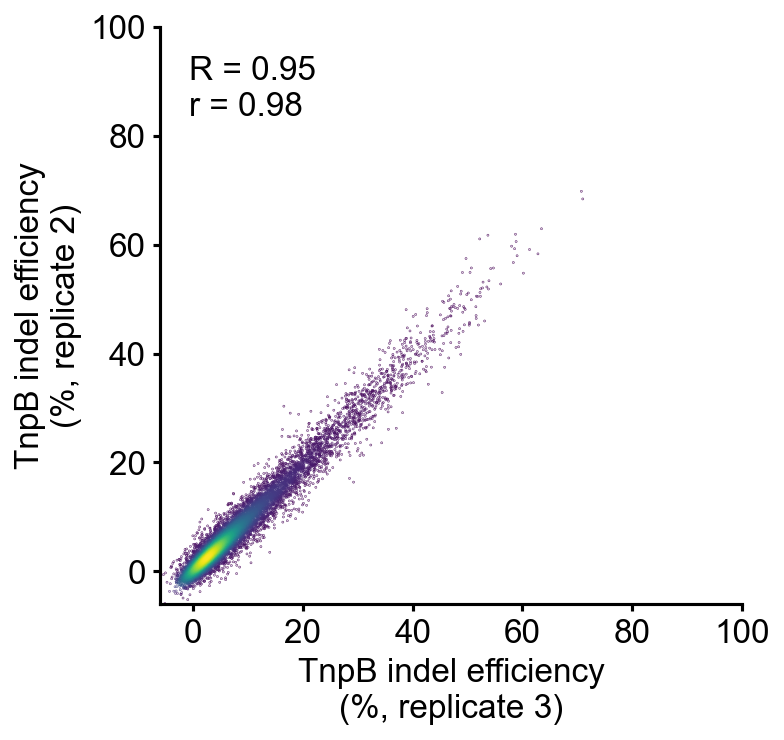

In [21]:
rep3eff = experimentdict['TnpBnuc_10']['TnpBnuc_10_3_percentageindel_corrected_individual'].reset_index(drop=True)
rep2eff = experimentdict['TnpBnuc_10']['TnpBnuc_10_2_percentageindel_corrected_individual'].reset_index(drop=True)
xy = np.vstack([rep3eff,rep2eff])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
Correlation_x, Correlation_y, Correlation_z_3_2 = rep3eff[idx], rep2eff[idx], z[idx]
rep3_2_R = stats.spearmanr(rep3eff, rep2eff)[0]
rep3_2_r = stats.pearsonr(rep3eff, rep2eff)[0]
fig, ax = plt.subplots(figsize = (5, 5),dpi=150)
ax.scatter(Correlation_x, Correlation_y, c=Correlation_z_1_2, s=0.05)
xlabels=[0,20,40,60,80,100]
# ax.xaxis.set_tick_params(width=2)
ax.tick_params(axis='x', labelsize= 16, width=1.5)
ax.tick_params(axis='y', labelsize= 16, width=1.5)
ax.set_xlabel('TnpB indel efficiency\n(%, replicate 3)', fontsize=16)
ax.set_ylabel('TnpB indel efficiency\n(%, replicate 2)', fontsize=16)
ax.set_xlim(-6, 100)
ax.set_ylim(-6, 100)
ax.set_xticks([0,20,40,60,80,100])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(0.05, 0.95, 'R = '+str(round(rep3_2_R, 2))+'\nr = '+str(round(rep3_2_r, 2)), transform=ax.transAxes, fontsize=16,
        verticalalignment='top')
figurepath = 'C:/Users/nicol/switchdrive/Institution/PhD/01_Experiments/05_Various/07_Kim_Marquart/TnpB/analysis/figures/'
plt.savefig(figurepath+'tnpB_indel_r3_r2_individual_correlation.pdf', format='pdf',
        transparent=True,bbox_inches='tight')
plt.show()

## Create Sequence Logo Plot for TnpB Nuclease

In [22]:
tnpb_nuclease_df = pd.read_csv('AnalysisFiles/summary/20221219_TnpBnuc_10_analysis_dataframe.csv')
tnpb_nuclease_df = tnpb_nuclease_df[tnpb_nuclease_df['lib_section'] != 'Custom_library_variants']  # only keep rows which do not have mismatches in protospacer etc. for this analysis
tnpb_nuclease_df['protopamseq'] = tnpb_nuclease_df.apply(lambda x: str(Seq(x['oligofinal'][-35-43:-43]).reverse_complement()),axis=1)
tnpb_nuclease_df = tnpb_nuclease_df.reset_index()
print(len(tnpb_nuclease_df))

basedistributiondict = {}
for pos in range(0,36):
        basedistributiondict[pos] = {}

for pos in range(0,36):
    for base in ['A','G','C','T']:
        basedistributiondict[pos][base] = [] 

10211


In [23]:
for index, row in tnpb_nuclease_df.iterrows():
    for ind, base in enumerate(row.protopamseq):
        basedistributiondict[ind][base].append(row.TnpBnuc_10_averageindel)

In [24]:
averagebasedistributiondict = {}
for pos in range(0,36):
        averagebasedistributiondict[pos] = {}
for pos in range(0,36):
    for base in ['A','G','C','T']:
        if len(basedistributiondict[pos][base]) == 0:
            mean = None
        else:
            mean = sum(basedistributiondict[pos][base])/len(basedistributiondict[pos][base])
        averagebasedistributiondict[pos][base] = mean

In [25]:
logomakerdf = pd.DataFrame(columns=['pos','A','C','G','T'])
logomakerdf = logomakerdf.set_index('pos')
logomakerdf
for position in averagebasedistributiondict:
    for base in ['A','G','C','T']:
        logomakerdf.at[position,base] = averagebasedistributiondict[position][base]

averageall = tnpb_nuclease_df.TnpBnuc_10_averageindel.mean()
averageall
logomakerposnegdf = logomakerdf.copy() - averageall
logomakerposnegdf
type(logomakerdf)

pandas.core.frame.DataFrame

In [26]:
logomakerdf = logomakerdf.apply(lambda col:pd.to_numeric(col, errors='coerce'))
logomakerdf = logomakerdf.fillna(0)
logomakerposnegdf = logomakerposnegdf.apply(lambda col:pd.to_numeric(col, errors='coerce'))
logomakerposnegdf = logomakerposnegdf.fillna(0)

meta NOT subset; don't know how to subset; dropped


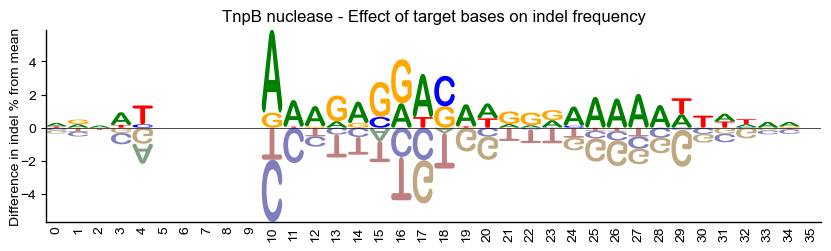

In [27]:
crp_logo = logomaker.Logo(logomakerposnegdf,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold')

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)

# style using Axes methods
crp_logo.ax.set_ylabel("Difference in indel % from mean", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)
crp_logo.ax.set_title('TnpB nuclease - Effect of target bases on indel frequency')
figurepath = 'figures/'
plt.savefig(figurepath+'20221220_TnpB_nuclease_Sequence_Logo_relativetomean.pdf', format='pdf',
        transparent=True,bbox_inches='tight')
plt.show()

In [28]:
tnpb_nuclease_df['group'] = tnpb_nuclease_df.Identifier.apply(lambda x: ''.join(x.split('_')[:-2]))

In [29]:
polytlist=[]
polyglist=[]
polyalist=[]
polyclist=[]
for index, row in tnpb_nuclease_df.iterrows():
    polytvalue = 0
    polygvalue = 0
    polyavalue = 0
    polycvalue = 0
    protospacer = row['spacer']

    for x in range(1,20):
        if ('T'*x in protospacer):
            polytvalue = x
        if ('G'*x in protospacer):
            polygvalue = x
        if ('A'*x in protospacer):
            polyavalue = x
        if ('C'*x in protospacer):
            polycvalue = x
    polytlist.append(polytvalue)
    polyglist.append(polygvalue)
    polyalist.append(polyavalue)
    polyclist.append(polycvalue)
tnpb_nuclease_df['polytvalues']=polytlist
tnpb_nuclease_df['polygvalues']=polyglist
tnpb_nuclease_df['polyavalues']=polyalist
tnpb_nuclease_df['polycvalues']=polyclist

In [30]:
tnpb_nuclease_df['Proto_GC_content'] = [GC(x) for x in tnpb_nuclease_df['spacer'].tolist()]
tnpb_nuclease_df['Proto_GC_count'] = tnpb_nuclease_df.apply(lambda x: x['spacer'].count('G')+x['spacer'].count('C'), axis=1)

protospacermt = tnpb_nuclease_df['spacer'].apply(lambda x: mt.Tm_Wallace(Seq(x)))
tnpb_nuclease_df['spacermt'] = protospacermt

In [31]:
tnpb_scaffold = 'gattcaagaatcccgaagtgaagaatcttgccgtccgtacatggacttgcccgaactgtggggaaacccatgaccgagacgagaacgctgcgctgaacattcggcgtgaagcgttggtggctgcgggaatctcagacaccttaaacgctcatggaggctatgtcagacctgcttcggcgggcaatggtctgcgaagtgagaatcacgcgactttagtcgtgtgaggttcaa'.upper()
HDV = 'ggccggcatggtcccagcctcctcgctggcgccggctgggcaacatgcttcggcatggcgaatgggac'.upper()
tnpb_nuclease_df['scaffold_spacer_HDV'] = tnpb_nuclease_df['spacer'].apply(lambda x: tnpb_scaffold + x + HDV)
tnpb_nuclease_df['spacer_HDV'] = tnpb_nuclease_df['spacer'].apply(lambda x: x + HDV)
tnpb_nuclease_df['scaffold_spacer'] = tnpb_nuclease_df['spacer'].apply(lambda x: tnpb_scaffold + x)

tnpb_nuclease_df.to_csv("20230114_tnpb_nuclease_df.csv")

In [32]:
### Run this script on linux where ViennaRNA is installed:

#import pandas as pd
#import RNA

# Load the dataframe
#df = pd.read_csv("20230114_tnpb_nuclease_df.csv")

# Create new columns for the MFE values
#df["MFE_scaffold_spacer_HDV"] = df["scaffold_spacer_HDV"].apply(lambda x: RNA.fold(x)[1])
#df["MFE_spacer_HDV"] = df["spacer_HDV"].apply(lambda x: RNA.fold(x)[1])
#df["MFE_scaffold_spacer"] = df["scaffold_spacer"].apply(lambda x: RNA.fold(x)[1])

#Selecting the columns we want to keep
#df = df[['scaffold_spacer_HDV','spacer_HDV','scaffold_spacer','MFE_scaffold_spacer_HDV','MFE_spacer_HDV','MFE_scaffold_spacer']]

# Save the dataframe as a CSV file
#df.to_csv("20230114_tnpb_nuclease_df_MFE.csv", index=True)

In [33]:
# import MFE values
MFE_df = pd.read_csv('20230114_tnpb_nuclease_df_MFE.csv')
tnpb_nuclease_df["MFE_scaffold_spacer_HDV"] = MFE_df["MFE_scaffold_spacer_HDV"]
tnpb_nuclease_df["MFE_spacer_HDV"] = MFE_df["MFE_spacer_HDV"]
tnpb_nuclease_df["MFE_scaffold_spacer"] = MFE_df["MFE_scaffold_spacer"]

In [34]:
def split(word):
    return [char for char in word]
protoseq = tnpb_nuclease_df['spacer'].apply(lambda x: split(x))

protocolumnlist = ["protobase_"+str(x) for x in range(1,21)]
protoseqdf = pd.DataFrame(protoseq.to_list(), columns=protocolumnlist)
protoseqdf = protoseqdf.set_index(protoseq.index)
tnpb_nuclease_df = tnpb_nuclease_df.join(protoseqdf)

In [35]:
# create a function that finds the position of the revcomp-spacer in the oligofinal column
def reverse_comp_position(row):
    # get the reverse complement of the spacer
    spacer_rc = Seq(row["spacer"]).reverse_complement()
    # find the position of the reverse complement in the oligofinal column
    # and return the position from the right end of the string
    return len(row["oligofinal"]) - (row["oligofinal"].find(str(spacer_rc)) + len(spacer_rc))

# apply the function to each row of the dataframe
# and add the result as a new column "spacer_rc_position"
tnpb_nuclease_df["spacer_rc_position"] = tnpb_nuclease_df.apply(reverse_comp_position, axis=1)

# create a function that extracts a substring (the extended target) from the oligofinal column
def extract_sequence(row):
    # calculate the start and end positions of the substring, use 10bp before the start of the spacer (means 5bp before the TAM) and 5bp after the spacer
    start = len(row["oligofinal"]) - row["spacer_rc_position"] - 20 - 5
    end = len(row["oligofinal"]) - row["spacer_rc_position"] + 10
    # extract the substring and return its reverse complement to get the forward direction
    return str(Seq(row["oligofinal"][start:end]).reverse_complement())

# apply the function to each row of the dataframe
# and add the result as a new column "wide_original_target"
tnpb_nuclease_df["wide_original_target"] = tnpb_nuclease_df.apply(extract_sequence, axis=1)

In [36]:
def split(word):
    return [char for char in word]
target_seq = tnpb_nuclease_df['wide_original_target'].apply(lambda x: split(x))
target_column_list = ["target_base_"+str(x) for x in range(-9,26)]
target_seq_df = pd.DataFrame(target_seq.to_list(), columns=target_column_list)
target_seq_df = target_seq_df.set_index(target_seq.index)
tnpb_nuclease_df = tnpb_nuclease_df.join(target_seq_df)

In [37]:
### Count number of 4bp motifs for spacer
# First initialize a dictionary to store the k-mer counts
counts = {}

# Iterate over the rows in the original DataFrame
for i, row in tnpb_nuclease_df.iterrows():
    seq = row['spacer']
    kmer_counts = {}
    for j in range(len(seq)-1):
        kmer = seq[j:j+2]
        if kmer in kmer_counts:
            kmer_counts[kmer] += 1
        else:
            kmer_counts[kmer] = 1
    counts[i] = kmer_counts

# Create a new dataframe from the k-mer counts dictionary
kmer_df = pd.DataFrame.from_dict(counts, orient='index')

# Use the pd.concat() function to join the new dataframe to the original dataframe
tnpb_nuclease_df = pd.concat([tnpb_nuclease_df, kmer_df], axis=1)

In [38]:
### Count number of 3bp motifs for spacer
# Iterate over the rows in the original DataFrame
for i, row in tnpb_nuclease_df.iterrows():
    seq = row['spacer']
    for j in range(len(seq)-2):
        kmer = seq[j:j+3]
        if kmer in tnpb_nuclease_df.columns:
            tnpb_nuclease_df.loc[i, kmer] += 1
        else:
            tnpb_nuclease_df[kmer] = 0
            tnpb_nuclease_df.loc[i, kmer] = 1

In [39]:
### Count number of 4bp motifs for spacer
# First initialize a dictionary to store the k-mer counts
counts = {}

# Iterate over the rows in the original DataFrame
for i, row in tnpb_nuclease_df.iterrows():
    seq = row['spacer']
    kmer_counts = {}
    for j in range(len(seq)-3):
        kmer = seq[j:j+4]
        if kmer in kmer_counts:
            kmer_counts[kmer] += 1
        else:
            kmer_counts[kmer] = 1
    counts[i] = kmer_counts

# Create a new dataframe from the k-mer counts dictionary
kmer_df = pd.DataFrame.from_dict(counts, orient='index')

# Use the pd.concat() function to join the new dataframe to the original dataframe
tnpb_nuclease_df = pd.concat([tnpb_nuclease_df, kmer_df], axis=1)

In [40]:
# add position specific 4-mers based on logo-plot importance

tnpb_nuclease_df['pos_1_4mer'] = tnpb_nuclease_df['spacer'].str[:4]
tnpb_nuclease_df['pos_6_4mer'] = tnpb_nuclease_df['spacer'].str[5:9]
tnpb_nuclease_df['pos_7_4mer'] = tnpb_nuclease_df['spacer'].str[6:10]

In [47]:
featuredf = tnpb_nuclease_df.copy()

# cols = ['Unnamed: 0.1',
#        'TnpBnuc_10_averageindel', 'polytvalues', 'polygvalues',
#        'polyavalues', 'polycvalues', 'Proto_GC_content', 'Proto_GC_count',
#        'spacermt', 'protobase_1', 'protobase_2', 'protobase_3', 'protobase_4',
#        'protobase_5', 'protobase_6', 'protobase_7', 'protobase_8',
#        'protobase_9', 'protobase_10', 'protobase_11', 'protobase_12',
#        'protobase_13', 'protobase_14', 'protobase_15', 'protobase_16',
#        'protobase_17', 'protobase_18', 'protobase_19', 'protobase_20','pos_1_4mer','pos_6_4mer','pos_7_4mer']

cols = ['Unnamed: 0.1',
       'TnpBnuc_10_averageindel', 'polytvalues', 'polygvalues',
       'polyavalues', 'polycvalues', 'Proto_GC_content', 'Proto_GC_count',
       'spacermt', 'pos_1_4mer','pos_6_4mer','pos_7_4mer','MFE_scaffold_spacer_HDV','MFE_spacer_HDV','MFE_scaffold_spacer']

        
# add the target_column_list to cols
target_column_list = ["target_base_"+str(x) for x in range(-9,26)]
cols = cols + target_column_list

# Create a list of the four letters
bases = ['A', 'G', 'C', 'T']

# Generate all 3-mer combinations
threebpmotifs = [''.join(comb) for comb in product(bases, repeat=3)]

# Generate all 4-mer combinations
fourbpmotifs = [''.join(comb) for comb in product(bases, repeat=4)]

# add motifs to cols
cols = cols + fourbpmotifs

featuredf = featuredf[cols]
editvalue = 'TnpBnuc_10_averageindel'
y = featuredf[editvalue].values

cols.remove('Unnamed: 0.1')

In [48]:
featuredf = featuredf[cols].copy()
featuredf = featuredf.fillna(0)

featuredf.to_csv('20230112_TnpB_featuredf.csv')
feature_dummies = pd.get_dummies(featuredf).copy()

# drop the outcome column

feature_dummies.drop([editvalue], axis=1, inplace=True)


#create array based on feature_dummies
X = feature_dummies.values
y = featuredf[editvalue].values